In [1]:
from google.colab import drive
drive.mount("/contents")

Mounted at /contents


In [2]:
pwd

'/content'

In [2]:
!pip install easyfsl

In [ ]:
!unzip "/contents/MyDrive/few shot.zip"

In [1]:
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot
from torch.utils.data import Dataset
from torchvision.models import resnet18
from tqdm import tqdm
import numpy as np
from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average


In [119]:
import os
import pandas as pd
from torchvision.io import read_image
import cv2  as cv
from PIL import Image
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        im = torchvision.io.read_image(img_path)
        image = im
        # image = torch.from_numpy(np.array(im))
        label = torch.tensor(self.img_labels.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image.float(), label

    def label(self):
        data = self.img_labels
        s=[]
        for i,j in zip(data.iloc[:,0],data.iloc[:,1]):
            s.append(tuple([i,j]))
        return s

    def get_labels(self):
      return [x for x in data.iloc[:,1]]


In [120]:
image_size=640
train_set = CustomImageDataset("annotations_file.csv","img_dir",transform=transforms.Compose(
        [
            transforms.RandomResizedCrop(640),
            transforms.RandomHorizontalFlip(),
            # transforms.ToTensor(),
        ]
    ))

test_data = CustomImageDataset("annotations_file_test.csv","testing",transform=transforms.Compose(
        [
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(640),
            # transforms.ToTensor(),
        ]
    ))


In [121]:
 len(train_set.label())

1140

In [122]:
len(test_data.label())

5463

In [123]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [124]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores


convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()
print(convolutional_network)

model = PrototypicalNetworks(convolutional_network).cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [125]:
import pandas

data = pd.read_csv("/content/annotations_file_test.csv")

In [126]:
N_WAY = 2  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 10  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# The sampler needs a dataset with a "get_labels" method. Check the code if you have any doubt!
test_data.get_labels = lambda: [instance[1] for instance in test_data.label()]
test_sampler = TaskSampler(
    test_data, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_data,
    batch_sampler=test_sampler,
    num_workers=0,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

In [127]:
N_TRAINING_EPISODES = 15000
N_VALIDATION_TASKS = 100

# train_set.labels = [instance[1] for instance in train_set._flat_character_images]   #incorrect, ignore this line; the following line is correct.
train_set.get_labels = lambda: [instance[1] for instance in train_set.label()]

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=2,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

tensor([[[[132., 132., 132.,  ..., 153., 153., 152.],
          [132., 132., 132.,  ..., 153., 153., 152.],
          [132., 132., 132.,  ..., 154., 153., 152.],
          ...,
          [133., 133., 133.,  ..., 163., 163., 163.],
          [133., 133., 134.,  ..., 162., 162., 162.],
          [134., 134., 134.,  ..., 161., 161., 161.]],

         [[132., 132., 132.,  ..., 153., 153., 152.],
          [132., 132., 132.,  ..., 153., 153., 152.],
          [132., 132., 132.,  ..., 154., 153., 152.],
          ...,
          [133., 133., 133.,  ..., 163., 163., 163.],
          [133., 133., 134.,  ..., 162., 162., 162.],
          [134., 134., 134.,  ..., 161., 161., 161.]],

         [[132., 132., 132.,  ..., 153., 153., 152.],
          [132., 132., 132.,  ..., 153., 153., 152.],
          [132., 132., 132.,  ..., 154., 153., 152.],
          ...,
          [133., 133., 133.,  ..., 163., 163., 163.],
          [133., 133., 134.,  ..., 162., 162., 162.],
          [134., 134., 134.,  ...

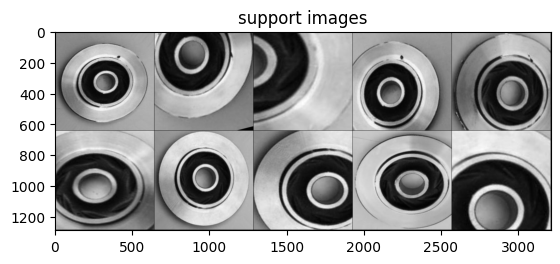

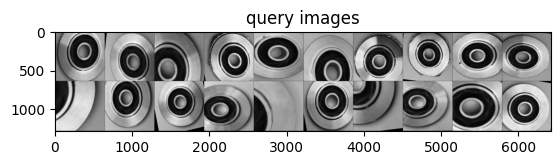

In [131]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(train_loader))

plot_images(example_support_images.int(), "support images", images_per_row=N_SHOT)
plot_images(example_query_images.int(), "query images", images_per_row=N_QUERY)
print(example_query_images)

In [132]:
iter(train_loader)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

In [ ]:
model.eval()
example_scores = model(
    example_support_images.cuda(),
    example_support_labels.cuda(),
    example_query_images.cuda(),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(
        f"{test_set._characters[example_class_ids[example_query_labels[i]]]} / {test_set._characters[example_class_ids[example_predicted_labels[i]]]}"
    )

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> torch.float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

In [134]:
def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,  # Changed the data type to LongTensor
    query_images: torch.Tensor,
    query_labels: torch.Tensor,  # Changed the data type to LongTensor
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    # Check the shape and data type of classification_scores tensor
    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()


In [ ]:
log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/15000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v

In [ ]:
evaluate(test_loader)


100%|██████████| 100/100 [01:44<00:00,  1.04s/it]

Model tested on 100 tasks. Accuracy: 99.20%


In [ ]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


In [ ]:
!unzip /content/final_test.zip

In [ ]:
final_set = CustomImageDataset("annotations_file_final_test.csv","final_test",transform=transforms.Compose(
        [
            transforms.RandomResizedCrop(640),
            transforms.RandomHorizontalFlip(),
            #transforms.ToTensor(),
        ]
    ))

In [ ]:
N_WAY = 2  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 10  # Number of images per class in the query set
N_EVALUATION_TASKS = 200

# The sampler needs a dataset with a "get_labels" method. Check the code if you have any doubt!
final_set.get_labels = lambda: [instance[1] for instance in final_set.label()]
final_sampler = TaskSampler(
    final_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

final_loader = DataLoader(
    final_set,
    batch_sampler=final_sampler,
    num_workers=0,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

In [ ]:
evaluate(final_loader)


100%|██████████| 200/200 [02:03<00:00,  1.61it/s]

Model tested on 200 tasks. Accuracy: 97.92%


In [ ]:
torch.save(model, "/content/model_scripted.pt")

In [ ]:
np.where(train_set.label()[1] ==1)

(array([], dtype=int64),)

In [ ]:
train_set.label()

[('cast_def_0_112_jpeg.rf.86da828464d92f2469e5c1af1eb29bbc.jpg', 0),
 ('cast_def_0_112_jpeg.rf.acf88565f1a9efbfd60856b5f6e556ed.jpg', 0),
 ('cast_def_0_112_jpeg.rf.bbe4d0fe4f69fc053f50e4dc5688af4c.jpg', 0),
 ('cast_def_0_112_jpeg.rf.d56249b50593f0a98e4b30720ea6abc7.jpg', 0),
 ('cast_def_0_112_jpeg.rf.ed212304b82ce05348d8adfa03f51f66.jpg', 0),
 ('cast_def_0_116_jpeg.rf.39545ea4462b5b8302e21a1e80d96cdf.jpg', 0),
 ('cast_def_0_116_jpeg.rf.3d8be248d02eda4fa8737c7fe75bcdf6.jpg', 0),
 ('cast_def_0_116_jpeg.rf.9d296adeb0b44cba279ca14a80ffbec0.jpg', 0),
 ('cast_def_0_116_jpeg.rf.a70c81222496b5294c498046fd802c13.jpg', 0),
 ('cast_def_0_116_jpeg.rf.df557879a44cbf6f2c45e81ecbdb07e2.jpg', 0),
 ('cast_def_0_116_jpeg.rf.e42448af90bd2ef3a30d32d9cb47040c.jpg', 0),
 ('cast_def_0_133_jpeg.rf.046138dc7ce573e88aafad452605f5f4.jpg', 0),
 ('cast_def_0_133_jpeg.rf.466940edfb12603c855c36410d4afe44.jpg', 0),
 ('cast_def_0_133_jpeg.rf.85e735dc1929def98c99aff734010b99.jpg', 0),
 ('cast_def_0_133_jpeg.rf.c259b9a2